In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import cmcrameri.cm as cm

from tqdm import tqdm
from utils import ELFData, ELFModel

## Load and filter data

In [2]:
# Perform center crop
center = False

In [3]:
# Load data
unlabeled = ELFData()
unlabeled.load_processed(dirname='data/unlabeled', structure=False)
print('Number of examples:', len(unlabeled.data))
unlabeled.data.head()

Parse profiles: 100%|██████████| 320585/320585 [00:19<00:00, 16678.34it/s]      


Number of examples: 320585


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,edge_dst,l,r_diff,g_diff,specie_src,specie_dst,mixed,id
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,4,3.812422,1.2,16,K,Cl,False,0
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,5,3.812422,1.2,16,K,Cl,False,0
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,6,3.812422,1.2,16,K,Cl,False,0
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,7,3.812422,1.2,16,K,Cl,False,0
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,8,3.812422,1.2,16,K,Cl,False,0


In [4]:
# Center crop
if center:
    dx = len(unlabeled.data.iloc[0]['elf'])//4
    unlabeled.data['elf'] = unlabeled.data['elf'].apply(lambda x: x[dx:-dx])

In [5]:
# Sort and filter data
unlabeled.data = unlabeled.data[~unlabeled.data['mixed']]
unlabeled.get_pdf_cdf()
unlabeled.sort_by_cdf()
print('Number of examples:', len(unlabeled.data))
unlabeled.data.head()

Number of examples: 279511


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,...,specie_src,specie_dst,mixed,id,A,pdf,cdf,elf_srt,pdf_srt,cdf_srt
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.2036299837170363, 0.284...","[0.014509947675761763, 0.017329271852047804, 0...","[0.014509947675761763, 0.03183921952780957, 0...."
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.20362998371703642, 0.28...","[0.014509947675761763, 0.017329271852047815, 0...","[0.014509947675761763, 0.031839219527809576, 0..."
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,K,Cl,False,0,12.044611,"[0.00012725870353490256, 0.0005892596846916265...","[0.00012725870353490256, 0.000716518388226529,...","[0.22271259596505436, 0.18323072767531332, 0.1...","[0.018490642709179408, 0.015212673105021801, 0...","[0.018490642709179408, 0.03370331581420121, 0...."
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.2036299837170363, 0.284...","[0.014509947675761763, 0.017329271852047804, 0...","[0.014509947675761763, 0.03183921952780957, 0...."
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,K,Cl,False,0,12.044611,"[0.00012725870353490256, 0.0005892596846916265...","[0.00012725870353490256, 0.000716518388226529,...","[0.2227125959650543, 0.18323072767531332, 0.19...","[0.0184906427091794, 0.015212673105021801, 0.0...","[0.0184906427091794, 0.033703315814201204, 0.0..."


### Calculate columns

In [6]:
unlabeled.data['pdf-l_srt'] = unlabeled.data[['pdf_srt', 'l']].apply(
    lambda x: x.pdf_srt/(x.l/len(x.pdf_srt)), axis=1)

unlabeled.data['cdf-A_srt'] = unlabeled.data[['cdf_srt', 'A']].apply(lambda x: x.cdf_srt*x.A, axis=1)

## Predict data classes

In [49]:
import importlib, sys
importlib.reload(sys.modules['utils'])
from utils import ELFModel

In [50]:
n_classes = 4
n_components = 10
columns = [['elf_srt'], ['pdf_srt'], ['pdf-l_srt'], ['cdf_srt'], ['cdf-A_srt']]
features = ['l', 'A']
n_estimators = 150
max_depth = 12

### Load models

In [51]:
savedir = 'models/'
if len(columns[0][0].split('_')) > 1:
    tag = '_' + columns[0][0].split('_')[-1]
else:
    tag = ''
models = []
for column in columns:
    column_name = '_'.join([''.join(k.split('_')[:-1]) for k in column]) + tag
    path = '_'.join([j + str(k) for (j,k) in zip(['c', 'z', 'n', 'd'],
                     [n_classes, n_components, n_estimators, max_depth])] + [column_name] + features)
    if center:
        path += '_cen'
    
    models.append(ELFModel(n_classes))
    models[-1].load_model(savedir + path)

### Predict

In [65]:
for i in tqdm(range(len(columns)), bar_format=unlabeled.bar_format):
    models[i].prepare_inputs(unlabeled.data)
    unlabeled.data = models[i].clf_predict(unlabeled.data)

100%|██████████| 5/5 [00:44<00:00,  8.91s/it]                                   


In [53]:
unlabeled.data.head()

,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,...,pdf-l_srt_pred,pdf-l_srt_pred_proba,z_cdf_srt,cdf_srt_pred,cdf_srt_pred_proba,z_cdf-A_srt,cdf-A_srt_pred,cdf-A_srt_pred_proba,l_bin,A_bin
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,3,0.906667,"[0.5477923213645961, 0.1756069425046739, -0.12...",3,0.666667,"[-11.679129332372087, 5.34837493718681, 0.0860...",3,0.520000,7,3
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,3,0.906667,"[0.5477923213645961, 0.1756069425046739, -0.12...",3,0.666667,"[-11.679129332372087, 5.34837493718681, 0.0860...",3,0.520000,7,3
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,3,0.753333,"[0.42778502661990725, 0.039773129189327176, -0...",3,0.640000,"[-11.538736624581107, 4.111602767696614, -1.25...",3,0.466667,7,3
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,3,0.906667,"[0.5477923213645961, 0.1756069425046739, -0.12...",3,0.666667,"[-11.679129332372087, 5.34837493718681, 0.0860...",3,0.520000,7,3
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,3,0.753333,"[0.42778502661990725, 0.039773129189327176, -0...",3,0.640000,"[-11.538736624581107, 4.111602767696614, -1.25...",3,0.466667,7,3


## Analyze predictions

### Class distribution per length and area bin

In [54]:
n_bins = 10
_, bins = np.histogram(unlabeled.data['l'], bins=n_bins)
unlabeled.data['l_bin'] = np.digitize(unlabeled.data['l'], bins[:-1], right=False).tolist()

_, bins = np.histogram(unlabeled.data['A'], bins=n_bins)
unlabeled.data['A_bin'] = np.digitize(unlabeled.data['A'], bins[:-1], right=False).tolist()

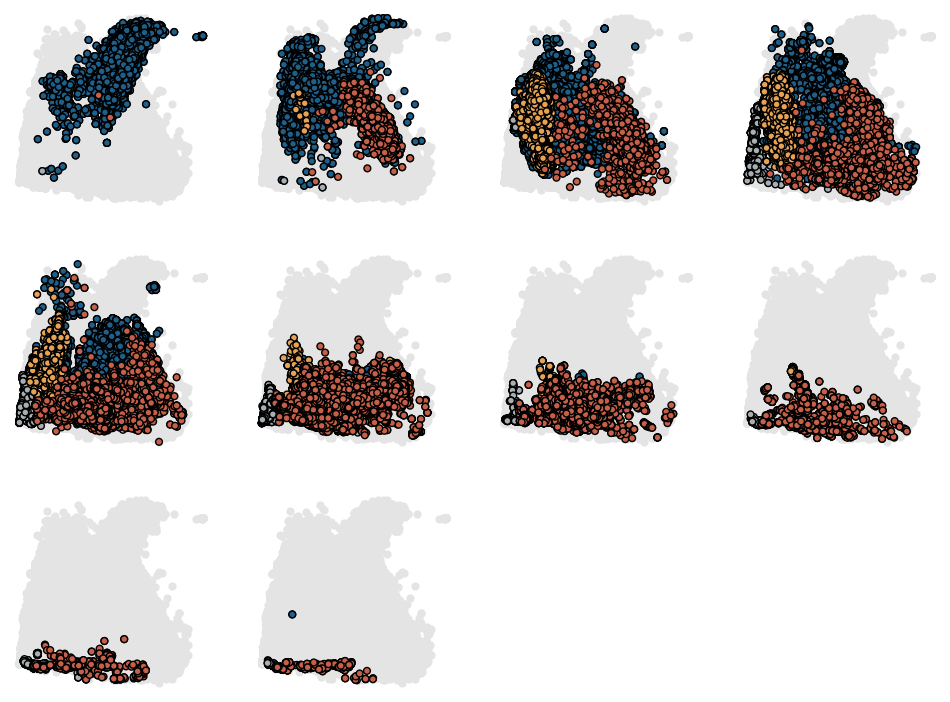

In [55]:
i = 0
index = 0
column = '_'.join([''.join(k.split('_')[:-1]) for k in columns[i]]) + tag
x = [np.stack(unlabeled.data.loc[unlabeled.data['l_bin']==k,
                                 'z_' + columns[i][index]].values) for k in range(1,n_bins+1)]
y = [unlabeled.data.loc[unlabeled.data['l_bin']==k, column + '_pred'].values for k in range(1,n_bins+1)]
fig = models[i].plot_projection_slices(x=x, y=y, axes=[0,1], cmap=models[i].dmap, order=True, index=index)

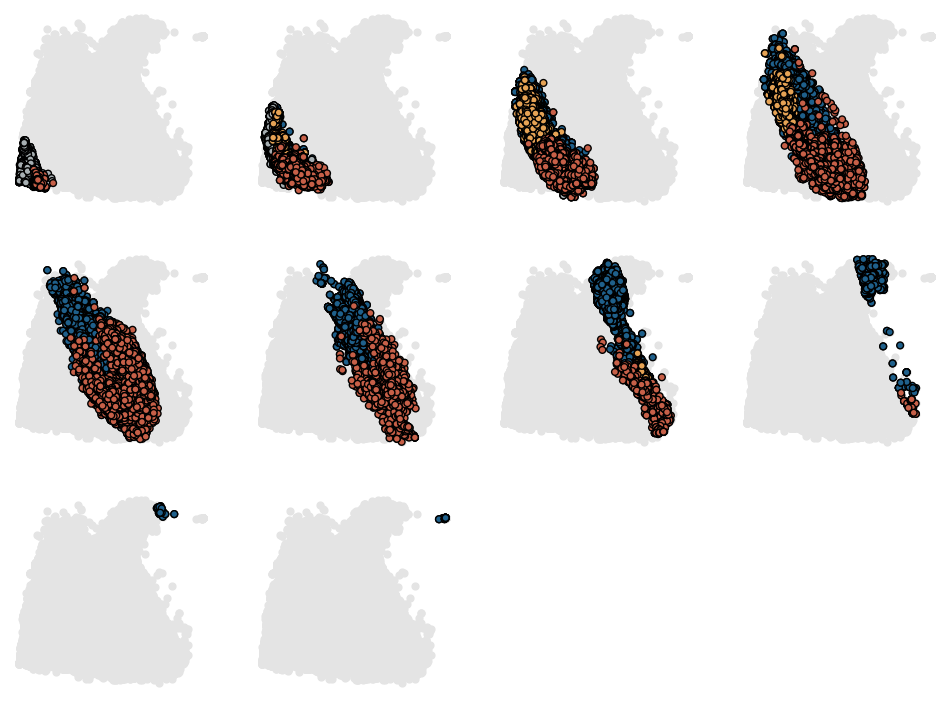

In [56]:
x = [np.stack(unlabeled.data.loc[unlabeled.data['A_bin']==k,
                                 'z_' + columns[i][index]].values) for k in range(1,n_bins+1)]
y = [unlabeled.data.loc[unlabeled.data['A_bin']==k, column + '_pred'].values for k in range(1,n_bins+1)]
fig = models[i].plot_projection_slices(x=x, y=y, axes=[0,1], cmap=models[i].dmap, order=True, index=index)

### Inspect candidate MDHs

In [143]:
formulas = [473, 479, 736, 816, 1125, 1413, 1511, 1587, 1684, 2306, 2344, 2430, 2975]
threshold = 0.6
column = columns[0]
column_name = '_'.join([''.join(k.split('_')[:-1]) for k in column]) + tag
mdh = unlabeled.get_mdhs(column=column_name, n_classes=n_classes, threshold=threshold, formulas=None)

Number of candidate MDHs: 1129


159


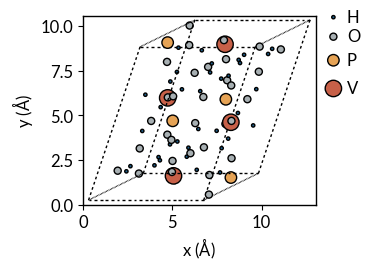

In [144]:
i = 29
entry = mdh.iloc[i]
print(entry.formula)
struct = entry.structure
unlabeled.plot_structure(struct, rotation=('0x,0y,0z'));

In [145]:
thresholds = np.arange(0.,0.9,0.05)
column = columns[0]
n_mdh = np.zeros_like(thresholds)
for i, threshold in enumerate(thresholds):
    column_name = '_'.join([''.join(k.split('_')[:-1]) for k in column]) + tag
    try: n_mdh[i] = len(unlabeled.get_mdhs(column_name, n_classes, threshold))
    except:
        break

Number of candidate MDHs: 1132
Number of candidate MDHs: 1132
Number of candidate MDHs: 1132
Number of candidate MDHs: 1132
Number of candidate MDHs: 1132
Number of candidate MDHs: 1132
Number of candidate MDHs: 1132
Number of candidate MDHs: 1132
Number of candidate MDHs: 1132
Number of candidate MDHs: 1131
Number of candidate MDHs: 1131
Number of candidate MDHs: 1130
Number of candidate MDHs: 1129
Number of candidate MDHs: 1128
Number of candidate MDHs: 1122
Number of candidate MDHs: 1114
Number of candidate MDHs: 1106
Number of candidate MDHs: 1055


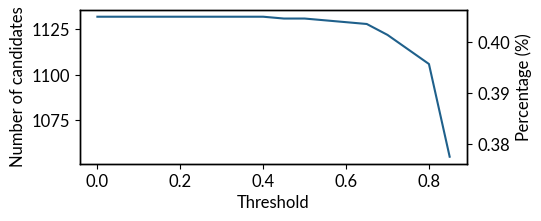

In [146]:
fig, ax = plt.subplots(figsize=(5,2))
_ax = ax.twinx()
ax.plot(thresholds, n_mdh, color='white')
_ax.plot(thresholds, 100*n_mdh/len(unlabeled.data), color=unlabeled.palette[0])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of candidates');
_ax.set_ylabel('Percentage (%)');